In [1]:
import pybamm
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from SALib.plotting.bar import plot as barplot

In [10]:
# Define the model
def battery_model(parameters):
    # Creating a DFN model
    model = pybamm.lithium_ion.DFN()
    
    # Loading the default parameter set
    param = model.default_parameter_values
    param["Separator porosity"] = 0.5
    # Updating parameters
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        # "Negative electrode diffusivity [m2.s-1]": parameters[17],
        # "Positive electrode diffusivity [m2.s-1]": parameters[18],
        # "Electrolyte diffusivity [m2.s-1]": parameters[19],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20],
        # "Separator porosity": parameters[21]
    })
    
    # Creating a Casadi solver and setting options
    solver = pybamm.CasadiSolver(
        mode="safe", 
        atol=1e-1, 
        rtol=1e-1, 
        dt_max=0.01,  # Decrease the maximum time step
        max_step_decrease_count=2000  # Increase in step size decrease in frequency
    )
    
    # Creating a Simulation
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
    
    # running simulation
    try:
        sim.solve([0, 450])  # Reduced simulation time range of 450 seconds
    except pybamm.SolverError as e:
        print(f"Solver failed for parameters: {parameters} with error: {e}")
        return np.nan  # Returns NaN to continue processing other combinations of parameters
    
    # Extract simulation results
    solution = sim.solution
    voltage = solution["Terminal voltage [V]"].entries
    
    # Returns the voltage at the end of the simulation
    return voltage[-1]


In [11]:
# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': ['Negative electrode thickness [m]', 
              'Positive electrode thickness [m]', 
              'Separator thickness [m]',
              'Negative electrode active material volume fraction',
              'Positive electrode active material volume fraction',
              'Negative particle radius [m]',
              'Positive particle radius [m]',
              'Initial concentration in electrolyte [mol.m-3]',
              'Negative electrode conductivity [S.m-1]',
              'Positive electrode conductivity [S.m-1]',
              'Negative electrode Bruggeman coefficient (electrode)',
              'Positive electrode Bruggeman coefficient (electrode)',
              'Separator Bruggeman coefficient (electrolyte)',
              'Maximum concentration in negative electrode [mol.m-3]',
              'Maximum concentration in positive electrode [mol.m-3]',
              'Electrode height [m]',
              'Electrode width [m]'
              # 'Negative electrode diffusivity [m2.s-1]',
              # 'Positive electrode diffusivity [m2.s-1]',
              # 'Electrolyte diffusivity [m2.s-1]',
              'Negative electrode double-layer capacity [F.m-2]',
              'Positive electrode double-layer capacity [F.m-2]',
              'Negative electrode porosity',
              'Positive electrode porosity',
              # 'Separator porosity',
              # 'tranfernumber',
              
              
              ],
    'bounds': [[9e-5, 11e-5],  # Narrowing down the parameters 0.0001
               [9e-5, 11e-5],  #0.0001
               [1e-5, 3e-5],  #2.5e-05
               [0.6, 0.7],      #0.6
               [0.35, 0.5],     #0.5
               [1e-5, 2e-5],    #1e-05
               [1e-5, 2e-5],    #1e-05
               [1e3, 1.2e3],    #1000
               [1e2, 2e2],      #100
               [9, 15],        #10
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [2.3e4, 3.4e4],  #24983.2619938437
               [5.0e4, 5.3e4],  #51217.9257309275
               [0.1, 0.15],     #0.137     
               [0.2, 0.25],     #0.207
               # [5e-14, 10e-14],  
               # [5e-14, 10e-14], 
               # [1.5e-14, 4.5e-14], 
               [0.1, 1],        #0.2
               [0.1, 1],        #0.2
               [0.26, 0.5],     #0.3
               [0.27, 0.45],    #0.3
               # [0.4, 0.55]      #0.5
               
               ]       
}

In [12]:
# Generate a sample
param_values = saltelli.sample(problem, 128)  # Further reduction of sample size to improve debugging efficiency

In [13]:
# Print a sample of the generated parameters
print("Generated parameter samples:")
print(param_values)

Generated parameter samples:
[[9.02343750e-05 9.66406250e-05 1.58593750e-05 ... 1.73828125e-01
  3.94062500e-01 4.23984375e-01]
 [9.11718750e-05 9.66406250e-05 1.58593750e-05 ... 1.73828125e-01
  3.94062500e-01 4.23984375e-01]
 [9.02343750e-05 1.07734375e-04 1.58593750e-05 ... 1.73828125e-01
  3.94062500e-01 4.23984375e-01]
 ...
 [9.88281250e-05 1.00703125e-04 1.44531250e-05 ... 9.75390625e-01
  3.20937500e-01 3.01640625e-01]
 [9.88281250e-05 1.00703125e-04 1.44531250e-05 ... 9.75390625e-01
  2.68437500e-01 3.26953125e-01]
 [9.88281250e-05 1.00703125e-04 1.44531250e-05 ... 9.75390625e-01
  2.68437500e-01 3.01640625e-01]]


In [14]:
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

In [15]:
 # Perform sensitivity analyses
Si = sobol.analyze(problem, Y_valid, print_to_console=True)

ValueError: Length of values (21) does not match length of index (20)

According to Wikipedia, sensitivity analysis is “the study of how the uncertainty in the output of a mathematical model or system (numerical or otherwise) can be apportioned to different sources of uncertainty in its inputs.” The sensitivity of each input is often represented by a numeric value, called the sensitivity index. Sensitivity indices come in several forms:
1. First order sensitivity indices (S1): measures the contribution to the output variance by a single model input alone.
2. Total sensitivity index (ST): measures the contribution to the output variance caused by a model input, including both its first-order effects (the input varying alone) and all higher-order interactions.
3. Second-order sensitivity indices (S2): measures the contribution to the output variance caused by the interaction of two model inputs.

In [42]:
# Print results
print("Sobol Sensitivity Indices")
print("S1:", Si['S1'])
print("ST:", Si['ST'])
print("S2:", Si['S2'])

Sobol Sensitivity Indices
S1: [-2.57023570e-03  4.86532261e-02 -5.60237116e-04 -3.44866818e-04
  1.51464303e-01  1.55749045e-02  2.43282217e-01 -3.14609747e-03
 -2.16395852e-07  7.39751026e-05 -2.21856882e-06 -2.41863605e-05
  6.24496313e-11  4.14990113e-02  1.10483405e-01  3.19823721e-01
  8.93967691e-02]
ST: [8.66386021e-04 4.38902271e-02 8.76570512e-05 1.28250724e-03
 1.41340663e-01 1.15014576e-02 2.51277356e-01 3.18820393e-03
 6.85705781e-09 1.99010597e-06 4.41733355e-10 9.82965162e-07
 9.86338673e-20 3.76074107e-02 1.09803490e-01 3.19245926e-01
 1.00012195e-01]
S2: [[            nan  3.81658480e-03  3.71780497e-03  3.39926301e-03
   3.46228034e-03  3.64399553e-03  3.86846553e-03  3.91830183e-03
   3.73427801e-03  3.74494276e-03  3.73451609e-03  3.73030020e-03
   3.73446959e-03  5.40604579e-03  2.34773820e-03  4.11373192e-03
   3.70787202e-03]
 [            nan             nan -2.65851558e-02 -2.61182657e-02
  -2.71623673e-02 -2.77986084e-02 -2.66129456e-02 -2.61411226e-02
  -2.656

In [43]:
# Visualisation results
params = problem['names']

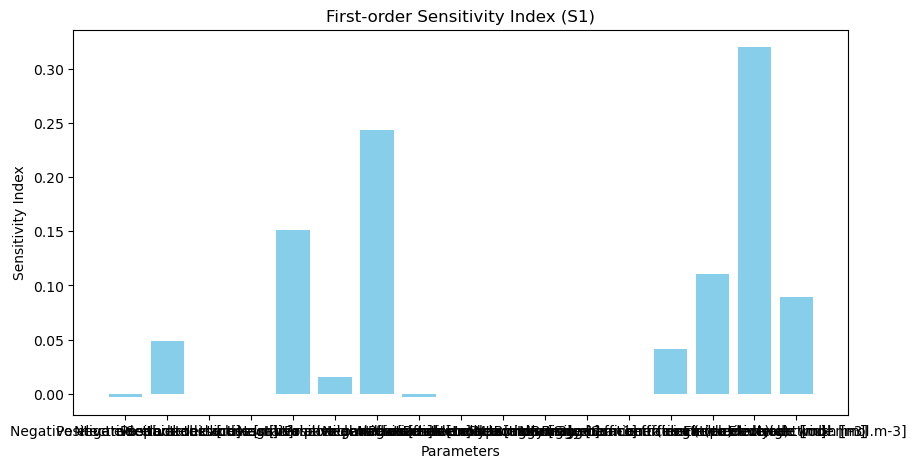

In [44]:
# First-order sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['S1'], color='skyblue')
plt.title('First-order Sensitivity Index (S1)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.show()

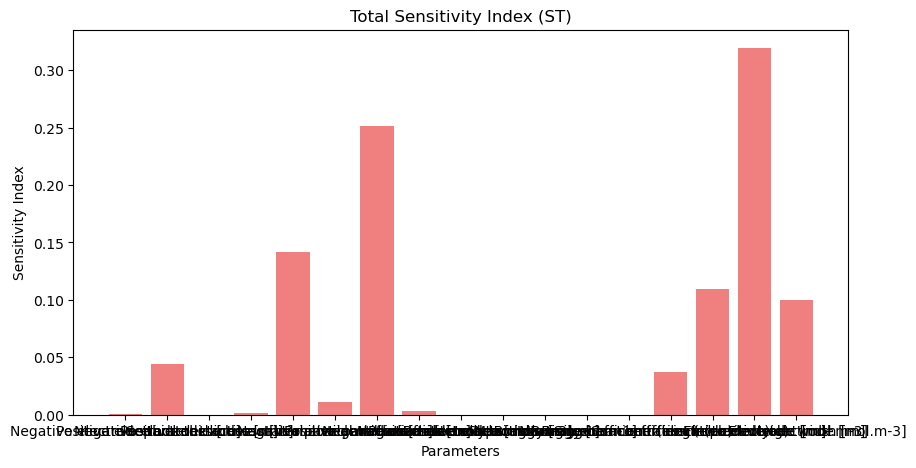

In [45]:
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.show()

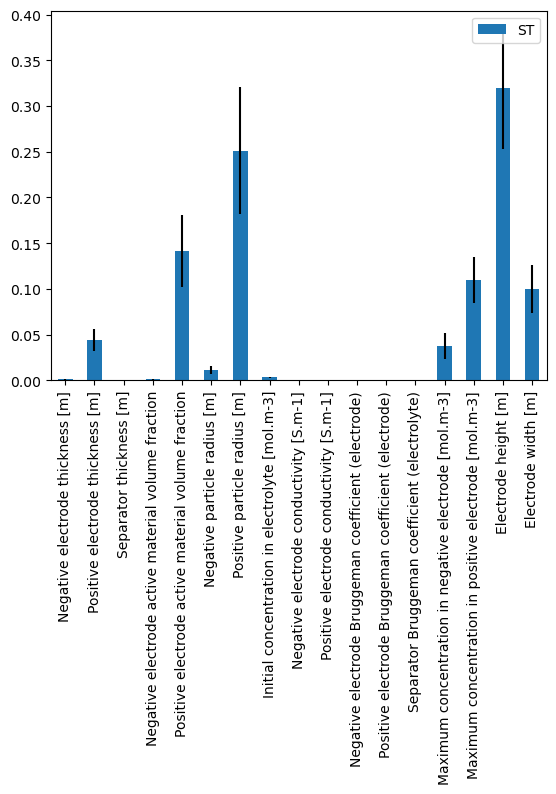

In [46]:
# Second-order sensitivity index(The second-order sensitivity index is a matrix that needs to be shown one by one)
# for i in range(len(params)):
#     for j in range(i+1, len(params)):
#         plt.figure(figsize=(10, 5))
#         plt.bar([f"{params[i]} & {params[j]}"], Si['S2'][i, j], color='lightgreen')
#         plt.title(f'Second-order Sensitivity Index (S2) between {params[i]} and {params[j]}')
#         plt.xlabel('Parameter Pairs')
#         plt.ylabel('Sensitivity Index')
#         plt.show()

Si_df = Si.to_df()
barplot(Si_df[0])
plt.show()

In [17]:
import pybamm
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from SALib.plotting.bar import plot as barplot

In [18]:
# Define the model
def battery_model(parameters):
    # Creating a DFN model
    model = pybamm.lithium_ion.DFN()
    
    # Loading the default parameter set
    param = model.default_parameter_values
    param["Separator porosity"] = 0.5  # Setting the Separator porosity directly
    
    # Updating parameters
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20],
        # "Separator porosity": parameters[21]  # Commented out since already set
    })
    
    # Creating a Casadi solver and setting options
    solver = pybamm.CasadiSolver(
        mode="safe", 
        atol=1e-1, 
        rtol=1e-1, 
        dt_max=0.01,  # Decrease the maximum time step
        max_step_decrease_count=2000  # Increase in step size decrease in frequency
    )
    
    # Creating a Simulation
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
    
    # Running simulation
    try:
        sim.solve([0, 450])  # Reduced simulation time range of 450 seconds
    except pybamm.SolverError as e:
        print(f"Solver failed for parameters: {parameters} with error: {e}")
        return np.nan  # Returns NaN to continue processing other combinations of parameters
    
    # Extract simulation results
    solution = sim.solution
    voltage = solution["Terminal voltage [V]"].entries
    
    # Returns the voltage at the end of the simulation
    return voltage[-1]

In [19]:

# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': ['Negative electrode thickness [m]', 
              'Positive electrode thickness [m]', 
              'Separator thickness [m]',
              'Negative electrode active material volume fraction',
              'Positive electrode active material volume fraction',
              'Negative particle radius [m]',
              'Positive particle radius [m]',
              'Initial concentration in electrolyte [mol.m-3]',
              'Negative electrode conductivity [S.m-1]',
              'Positive electrode conductivity [S.m-1]',
              'Negative electrode Bruggeman coefficient (electrode)',
              'Positive electrode Bruggeman coefficient (electrode)',
              'Separator Bruggeman coefficient (electrolyte)',
              'Maximum concentration in negative electrode [mol.m-3]',
              'Maximum concentration in positive electrode [mol.m-3]',
              'Electrode height [m]',
              'Electrode width [m]',
              'Negative electrode double-layer capacity [F.m-2]',
              'Positive electrode double-layer capacity [F.m-2]',
              'Negative electrode porosity',
              'Positive electrode porosity'
              ],
    'bounds': [[9e-5, 11e-5],  # Narrowing down the parameters 0.0001
               [9e-5, 11e-5],  #0.0001
               [1e-5, 3e-5],  #2.5e-05
               [0.6, 0.7],      #0.6
               [0.35, 0.5],     #0.5
               [1e-5, 2e-5],    #1e-05
               [1e-5, 2e-5],    #1e-05
               [1e3, 1.2e3],    #1000
               [1e2, 2e2],      #100
               [9, 15],        #10
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [2.3e4, 3.4e4],  #24983.2619938437
               [5.0e4, 5.3e4],  #51217.9257309275
               [0.1, 0.15],     #0.137     
               [0.2, 0.25],     #0.207
               [0.1, 1],        #0.2
               [0.1, 1],        #0.2
               [0.26, 0.5],     #0.3
               [0.27, 0.45]     #0.3
               ]       
}

In [20]:

# Generate a sample
param_values = saltelli.sample(problem, 128)  # Further reduction of sample size to improve debugging efficiency

In [21]:
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

In [22]:

# Perform sensitivity analyses
Si = sobol.analyze(problem, Y_valid, print_to_console=True)


                                                              ST       ST_conf
Negative electrode thickness [m]                    6.774056e-04  3.487158e-04
Positive electrode thickness [m]                    4.065260e-02  9.468496e-03
Separator thickness [m]                             7.175891e-04  1.919835e-04
Negative electrode active material volume fraction  1.041689e-03  4.273668e-04
Positive electrode active material volume fraction  1.428044e-01  3.871052e-02
Negative particle radius [m]                        1.187314e-02  5.445532e-03
Positive particle radius [m]                        2.670839e-01  6.128124e-02
Initial concentration in electrolyte [mol.m-3]      3.356542e-03  8.997356e-04
Negative electrode conductivity [S.m-1]             7.879667e-09  2.516984e-09
Positive electrode conductivity [S.m-1]             2.128747e-06  5.463717e-07
Negative electrode Bruggeman coefficient (elect...  4.494040e-10  1.447247e-10
Positive electrode Bruggeman coefficient (elect...  

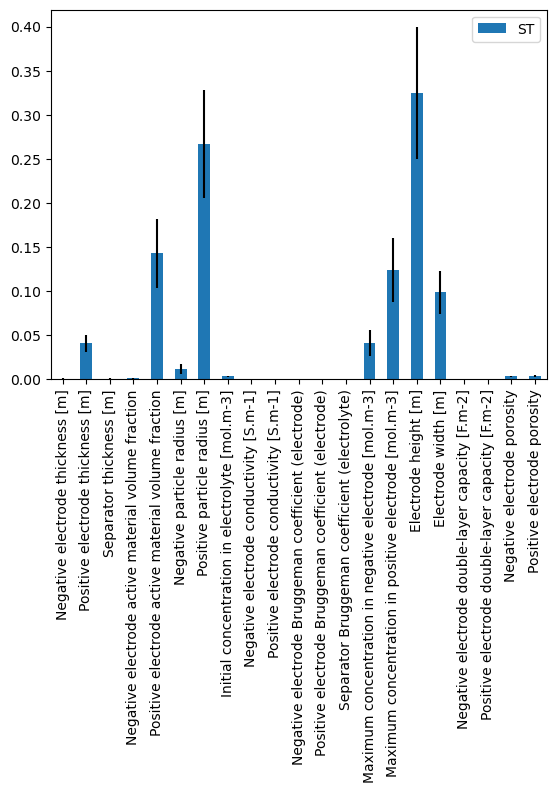

In [23]:
Si_df = Si.to_df()
barplot(Si_df[0])
plt.show()

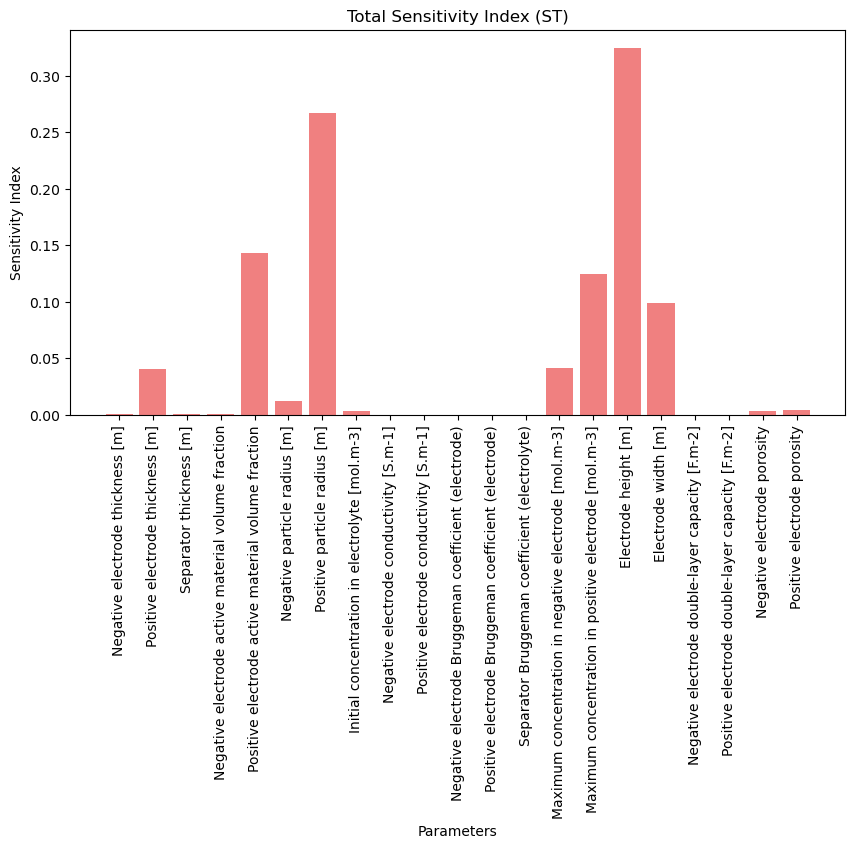

In [30]:
params = problem['names']
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()

In [31]:
# Define the model
def battery_model(parameters):
    # Creating a DFN model
    model = pybamm.lithium_ion.DFN()
    
    # Loading the default parameter set
    param = model.default_parameter_values
    param["Separator porosity"] = 0.5  # Setting the Separator porosity directly
    
    # Updating parameters
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20],
        # "Separator porosity": parameters[21]  # Commented out since already set
    })
    
    # Creating a Casadi solver and setting options
    solver = pybamm.CasadiSolver(
        mode="safe", 
        atol=1e-1, 
        rtol=1e-1, 
        dt_max=0.01,  # Decrease the maximum time step
        max_step_decrease_count=2000  # Increase in step size decrease in frequency
    )
    
    # Creating a Simulation
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
    
    # Running simulation
    try:
        sim.solve([0, 450])  # Reduced simulation time range of 450 seconds
    except pybamm.SolverError as e:
        print(f"Solver failed for parameters: {parameters} with error: {e}")
        return np.nan  # Returns NaN to continue processing other combinations of parameters
    
    # Extract simulation results
    solution = sim.solution
    voltage = solution["Terminal voltage [V]"].entries
    
    # Returns the voltage at the end of the simulation
    return voltage[0]

In [32]:

# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': ['Negative electrode thickness [m]', 
              'Positive electrode thickness [m]', 
              'Separator thickness [m]',
              'Negative electrode active material volume fraction',
              'Positive electrode active material volume fraction',
              'Negative particle radius [m]',
              'Positive particle radius [m]',
              'Initial concentration in electrolyte [mol.m-3]',
              'Negative electrode conductivity [S.m-1]',
              'Positive electrode conductivity [S.m-1]',
              'Negative electrode Bruggeman coefficient (electrode)',
              'Positive electrode Bruggeman coefficient (electrode)',
              'Separator Bruggeman coefficient (electrolyte)',
              'Maximum concentration in negative electrode [mol.m-3]',
              'Maximum concentration in positive electrode [mol.m-3]',
              'Electrode height [m]',
              'Electrode width [m]',
              'Negative electrode double-layer capacity [F.m-2]',
              'Positive electrode double-layer capacity [F.m-2]',
              'Negative electrode porosity',
              'Positive electrode porosity'
              ],
    'bounds': [[9e-5, 11e-5],  # Narrowing down the parameters 0.0001
               [9e-5, 11e-5],  #0.0001
               [1e-5, 3e-5],  #2.5e-05
               [0.6, 0.7],      #0.6
               [0.35, 0.5],     #0.5
               [1e-5, 2e-5],    #1e-05
               [1e-5, 2e-5],    #1e-05
               [1e3, 1.2e3],    #1000
               [1e2, 2e2],      #100
               [9, 15],        #10
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [2.3e4, 3.4e4],  #24983.2619938437
               [5.0e4, 5.3e4],  #51217.9257309275
               [0.1, 0.15],     #0.137     
               [0.2, 0.25],     #0.207
               [0.1, 1],        #0.2
               [0.1, 1],        #0.2
               [0.26, 0.5],     #0.3
               [0.27, 0.45]     #0.3
               ]       
}

In [33]:
# Generate a sample
param_values = saltelli.sample(problem, 128)  # Further reduction of sample size to improve debugging efficiency

In [34]:
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

In [35]:
# Perform sensitivity analyses
Si = sobol.analyze(problem, Y_valid, print_to_console=True)

                                                              ST       ST_conf
Negative electrode thickness [m]                    1.991926e-04  6.804442e-05
Positive electrode thickness [m]                    1.988830e-02  5.257638e-03
Separator thickness [m]                             3.926969e-04  1.142991e-04
Negative electrode active material volume fraction  2.163908e-04  6.792576e-05
Positive electrode active material volume fraction  7.288725e-02  2.019399e-02
Negative particle radius [m]                        4.985949e-03  1.536351e-03
Positive particle radius [m]                        2.658246e-01  6.300822e-02
Initial concentration in electrolyte [mol.m-3]      6.637238e-03  1.582840e-03
Negative electrode conductivity [S.m-1]             2.205330e-08  6.734070e-09
Positive electrode conductivity [S.m-1]             4.872685e-06  1.402559e-06
Negative electrode Bruggeman coefficient (elect...  1.359357e-09  4.440587e-10
Positive electrode Bruggeman coefficient (elect...  

In [36]:
params = problem['names']

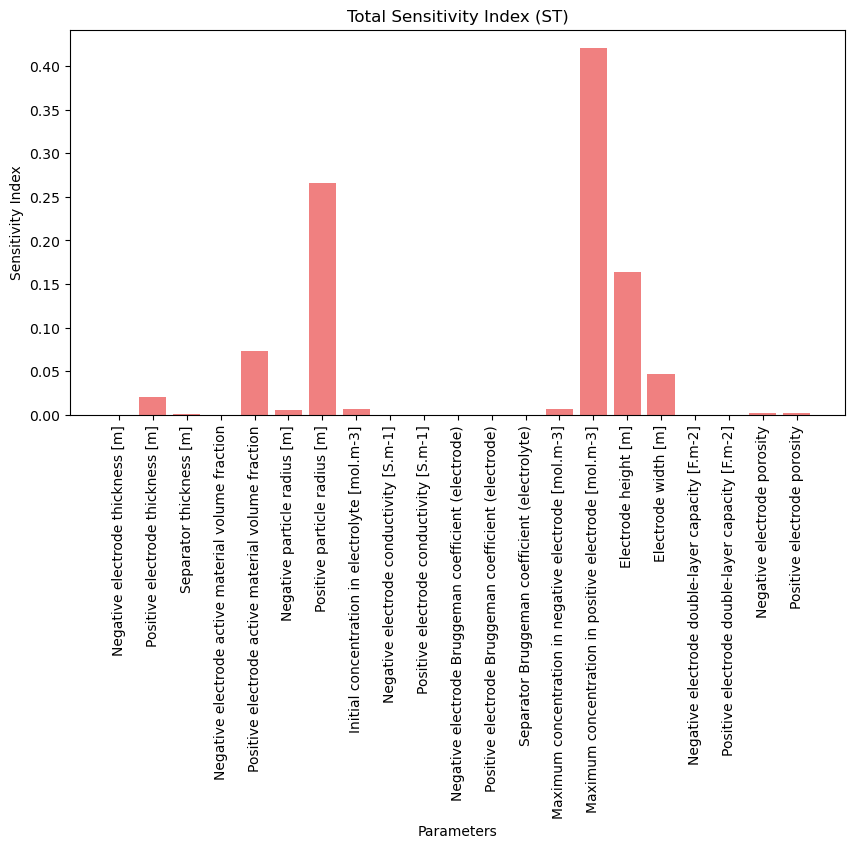

In [37]:
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()

In [38]:
# Define the model
def battery_model(parameters):
    # Creating a DFN model
    model = pybamm.lithium_ion.DFN()
    
    # Loading the default parameter set
    param = model.default_parameter_values
    param["Separator porosity"] = 0.5  # Setting the Separator porosity directly
    
    # Updating parameters
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20],
        # "Separator porosity": parameters[21]  # Commented out since already set
    })
    
    # Creating a Casadi solver and setting options
    solver = pybamm.CasadiSolver(
        mode="safe", 
        atol=1e-1, 
        rtol=1e-1, 
        dt_max=0.01,  # Decrease the maximum time step
        max_step_decrease_count=2000  # Increase in step size decrease in frequency
    )
    
    # Creating a Simulation
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
    
    # Running simulation
    try:
        sim.solve([0, 450])  # Reduced simulation time range of 450 seconds
    except pybamm.SolverError as e:
        print(f"Solver failed for parameters: {parameters} with error: {e}")
        return np.nan  # Returns NaN to continue processing other combinations of parameters
    
    # Extract simulation results
    solution = sim.solution
    voltage = solution["Terminal voltage [V]"].entries
    
    # Returns the voltage at the end of the simulation
    return voltage[49]

In [39]:

# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': ['Negative electrode thickness [m]', 
              'Positive electrode thickness [m]', 
              'Separator thickness [m]',
              'Negative electrode active material volume fraction',
              'Positive electrode active material volume fraction',
              'Negative particle radius [m]',
              'Positive particle radius [m]',
              'Initial concentration in electrolyte [mol.m-3]',
              'Negative electrode conductivity [S.m-1]',
              'Positive electrode conductivity [S.m-1]',
              'Negative electrode Bruggeman coefficient (electrode)',
              'Positive electrode Bruggeman coefficient (electrode)',
              'Separator Bruggeman coefficient (electrolyte)',
              'Maximum concentration in negative electrode [mol.m-3]',
              'Maximum concentration in positive electrode [mol.m-3]',
              'Electrode height [m]',
              'Electrode width [m]',
              'Negative electrode double-layer capacity [F.m-2]',
              'Positive electrode double-layer capacity [F.m-2]',
              'Negative electrode porosity',
              'Positive electrode porosity'
              ],
    'bounds': [[9e-5, 11e-5],  # Narrowing down the parameters 0.0001
               [9e-5, 11e-5],  #0.0001
               [1e-5, 3e-5],  #2.5e-05
               [0.6, 0.7],      #0.6
               [0.35, 0.5],     #0.5
               [1e-5, 2e-5],    #1e-05
               [1e-5, 2e-5],    #1e-05
               [1e3, 1.2e3],    #1000
               [1e2, 2e2],      #100
               [9, 15],        #10
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [2.3e4, 3.4e4],  #24983.2619938437
               [5.0e4, 5.3e4],  #51217.9257309275
               [0.1, 0.15],     #0.137     
               [0.2, 0.25],     #0.207
               [0.1, 1],        #0.2
               [0.1, 1],        #0.2
               [0.26, 0.5],     #0.3
               [0.27, 0.45]     #0.3
               ]       
}

In [40]:
# Generate a sample
param_values = saltelli.sample(problem, 128)  # Further reduction of sample size to improve debugging efficiency

In [41]:
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

In [42]:
# Perform sensitivity analyses
Si = sobol.analyze(problem, Y_valid, print_to_console=True)

                                                              ST       ST_conf
Negative electrode thickness [m]                    6.143920e-05  3.504363e-05
Positive electrode thickness [m]                    3.535172e-02  8.602999e-03
Separator thickness [m]                             7.967799e-04  2.146582e-04
Negative electrode active material volume fraction  2.523944e-04  1.057762e-04
Positive electrode active material volume fraction  1.242064e-01  3.032521e-02
Negative particle radius [m]                        4.238133e-03  1.321627e-03
Positive particle radius [m]                        3.148041e-01  6.940445e-02
Initial concentration in electrolyte [mol.m-3]      3.761724e-03  9.114075e-04
Negative electrode conductivity [S.m-1]             1.095212e-08  2.984992e-09
Positive electrode conductivity [S.m-1]             2.373498e-06  6.951019e-07
Negative electrode Bruggeman coefficient (elect...  6.610301e-10  1.957007e-10
Positive electrode Bruggeman coefficient (elect...  

In [43]:
params = problem['names']

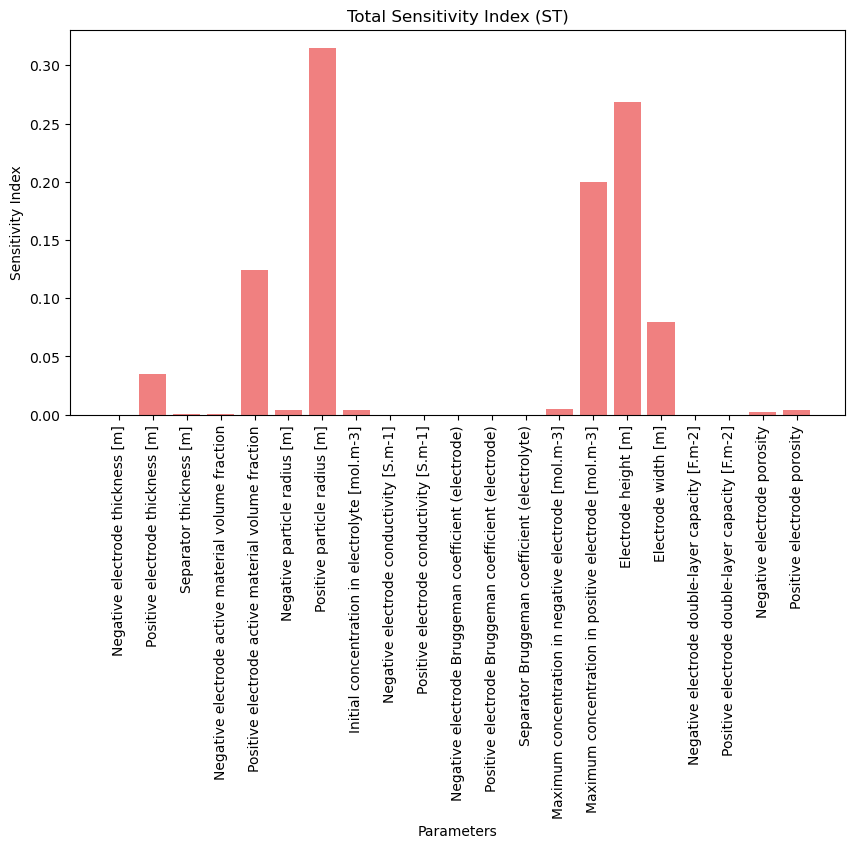

In [44]:
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()

In [45]:
# Define the model
def battery_model(parameters):
    # Creating a DFN model
    model = pybamm.lithium_ion.DFN()
    
    # Loading the default parameter set
    param = model.default_parameter_values
    param["Separator porosity"] = 0.5  # Setting the Separator porosity directly
    
    # Updating parameters
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20],
        # "Separator porosity": parameters[21]  # Commented out since already set
    })
    
    # Creating a Casadi solver and setting options
    solver = pybamm.CasadiSolver(
        mode="safe", 
        atol=1e-1, 
        rtol=1e-1, 
        dt_max=0.01,  # Decrease the maximum time step
        max_step_decrease_count=2000  # Increase in step size decrease in frequency
    )
    
    # Creating a Simulation
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
    
    # Running simulation
    try:
        sim.solve([0, 450])  # Reduced simulation time range of 450 seconds
    except pybamm.SolverError as e:
        print(f"Solver failed for parameters: {parameters} with error: {e}")
        return np.nan  # Returns NaN to continue processing other combinations of parameters
    
    # Extract simulation results
    solution = sim.solution
    voltage = solution["Terminal voltage [V]"].entries
    
    # Returns the voltage at the end of the simulation
    return voltage[24]

In [46]:

# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': ['Negative electrode thickness [m]', 
              'Positive electrode thickness [m]', 
              'Separator thickness [m]',
              'Negative electrode active material volume fraction',
              'Positive electrode active material volume fraction',
              'Negative particle radius [m]',
              'Positive particle radius [m]',
              'Initial concentration in electrolyte [mol.m-3]',
              'Negative electrode conductivity [S.m-1]',
              'Positive electrode conductivity [S.m-1]',
              'Negative electrode Bruggeman coefficient (electrode)',
              'Positive electrode Bruggeman coefficient (electrode)',
              'Separator Bruggeman coefficient (electrolyte)',
              'Maximum concentration in negative electrode [mol.m-3]',
              'Maximum concentration in positive electrode [mol.m-3]',
              'Electrode height [m]',
              'Electrode width [m]',
              'Negative electrode double-layer capacity [F.m-2]',
              'Positive electrode double-layer capacity [F.m-2]',
              'Negative electrode porosity',
              'Positive electrode porosity'
              ],
    'bounds': [[9e-5, 11e-5],  # Narrowing down the parameters 0.0001
               [9e-5, 11e-5],  #0.0001
               [1e-5, 3e-5],  #2.5e-05
               [0.6, 0.7],      #0.6
               [0.35, 0.5],     #0.5
               [1e-5, 2e-5],    #1e-05
               [1e-5, 2e-5],    #1e-05
               [1e3, 1.2e3],    #1000
               [1e2, 2e2],      #100
               [9, 15],        #10
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [2.3e4, 3.4e4],  #24983.2619938437
               [5.0e4, 5.3e4],  #51217.9257309275
               [0.1, 0.15],     #0.137     
               [0.2, 0.25],     #0.207
               [0.1, 1],        #0.2
               [0.1, 1],        #0.2
               [0.26, 0.5],     #0.3
               [0.27, 0.45]     #0.3
               ]       
}

In [47]:
# Generate a sample
param_values = saltelli.sample(problem, 128)  # Further reduction of sample size to improve debugging efficiency

In [48]:
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

In [49]:
# Perform sensitivity analyses
Si = sobol.analyze(problem, Y_valid, print_to_console=True)

                                                              ST       ST_conf
Negative electrode thickness [m]                    3.263482e-05  1.326752e-05
Positive electrode thickness [m]                    3.002884e-02  6.597240e-03
Separator thickness [m]                             8.493507e-04  2.575358e-04
Negative electrode active material volume fraction  1.564573e-04  4.743793e-05
Positive electrode active material volume fraction  1.056166e-01  2.628003e-02
Negative particle radius [m]                        3.437764e-03  8.520384e-04
Positive particle radius [m]                        3.181873e-01  7.245573e-02
Initial concentration in electrolyte [mol.m-3]      4.463599e-03  1.262518e-03
Negative electrode conductivity [S.m-1]             1.411178e-08  3.549331e-09
Positive electrode conductivity [S.m-1]             2.765588e-06  8.735819e-07
Negative electrode Bruggeman coefficient (elect...  9.209166e-10  2.723730e-10
Positive electrode Bruggeman coefficient (elect...  

In [50]:
params = problem['names']

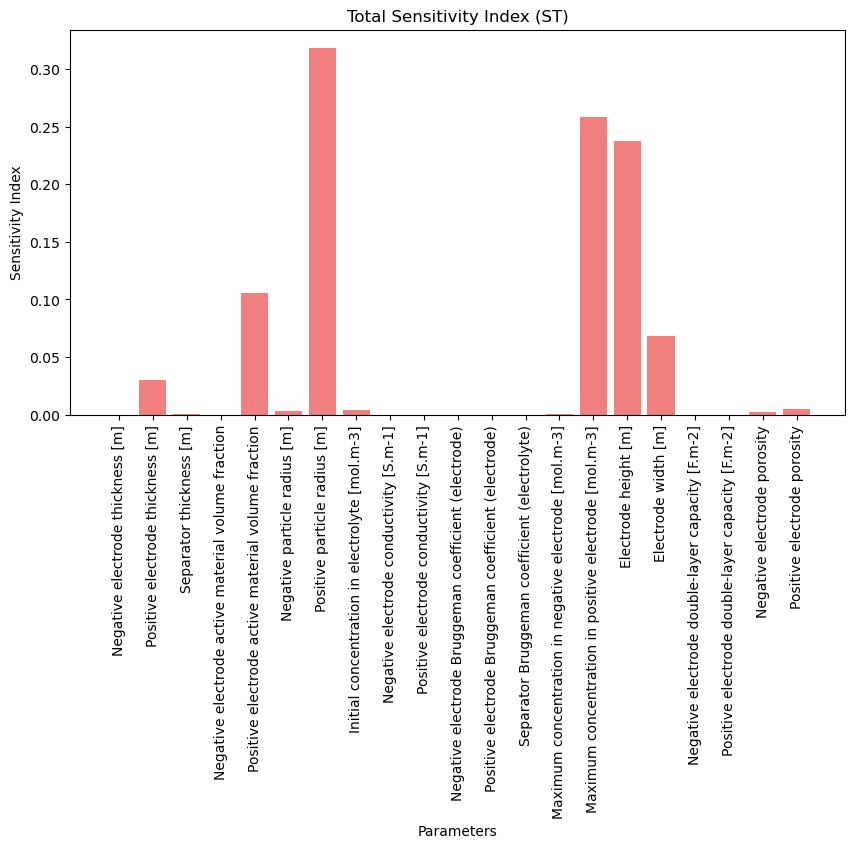

In [51]:
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()

In [57]:
# Define the model
def battery_model(parameters):
    # Creating a DFN model
    model = pybamm.lithium_ion.DFN()
    
    # Loading the default parameter set
    param = model.default_parameter_values
    param["Separator porosity"] = 0.5  # Setting the Separator porosity directly
    
    # Updating parameters
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20],
        # "Separator porosity": parameters[21]  # Commented out since already set
    })
    
    # Creating a Casadi solver and setting options
    solver = pybamm.CasadiSolver(
        mode="safe", 
        atol=1e-1, 
        rtol=1e-1, 
        dt_max=0.01,  # Decrease the maximum time step
        max_step_decrease_count=2000  # Increase in step size decrease in frequency
    )
    
    # Creating a Simulation
    sim = pybamm.Simulation(model, parameter_values=param, solver=solver)
    
    # Running simulation
    try:
        sim.solve([0, 450])  # Reduced simulation time range of 450 seconds
    except pybamm.SolverError as e:
        print(f"Solver failed for parameters: {parameters} with error: {e}")
        return np.nan  # Returns NaN to continue processing other combinations of parameters
    
    # Extract simulation results
    solution = sim.solution
    voltage = solution["Terminal voltage [V]"].entries
    
    # Returns the voltage at the end of the simulation
    return voltage[74]

In [58]:
# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': ['Negative electrode thickness [m]', 
              'Positive electrode thickness [m]', 
              'Separator thickness [m]',
              'Negative electrode active material volume fraction',
              'Positive electrode active material volume fraction',
              'Negative particle radius [m]',
              'Positive particle radius [m]',
              'Initial concentration in electrolyte [mol.m-3]',
              'Negative electrode conductivity [S.m-1]',
              'Positive electrode conductivity [S.m-1]',
              'Negative electrode Bruggeman coefficient (electrode)',
              'Positive electrode Bruggeman coefficient (electrode)',
              'Separator Bruggeman coefficient (electrolyte)',
              'Maximum concentration in negative electrode [mol.m-3]',
              'Maximum concentration in positive electrode [mol.m-3]',
              'Electrode height [m]',
              'Electrode width [m]',
              'Negative electrode double-layer capacity [F.m-2]',
              'Positive electrode double-layer capacity [F.m-2]',
              'Negative electrode porosity',
              'Positive electrode porosity'
              ],
    'bounds': [[9e-5, 11e-5],  # Narrowing down the parameters 0.0001
               [9e-5, 11e-5],  #0.0001
               [1e-5, 3e-5],  #2.5e-05
               [0.6, 0.7],      #0.6
               [0.35, 0.5],     #0.5
               [1e-5, 2e-5],    #1e-05
               [1e-5, 2e-5],    #1e-05
               [1e3, 1.2e3],    #1000
               [1e2, 2e2],      #100
               [9, 15],        #10
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [2.3e4, 3.4e4],  #24983.2619938437
               [5.0e4, 5.3e4],  #51217.9257309275
               [0.1, 0.15],     #0.137     
               [0.2, 0.25],     #0.207
               [0.1, 1],        #0.2
               [0.1, 1],        #0.2
               [0.26, 0.5],     #0.3
               [0.27, 0.45]     #0.3
               ]       
}

In [59]:
# Generate a sample
param_values = saltelli.sample(problem, 128)  # Further reduction of sample size to improve debugging efficiency

In [60]:
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

In [61]:
# Perform sensitivity analyses
Si = sobol.analyze(problem, Y_valid, print_to_console=True)

                                                              ST       ST_conf
Negative electrode thickness [m]                    2.608621e-04  1.458557e-04
Positive electrode thickness [m]                    3.902450e-02  1.012461e-02
Separator thickness [m]                             7.482328e-04  2.421756e-04
Negative electrode active material volume fraction  5.568297e-04  2.835150e-04
Positive electrode active material volume fraction  1.367405e-01  3.950331e-02
Negative particle radius [m]                        7.234137e-03  3.042977e-03
Positive particle radius [m]                        2.943206e-01  6.969661e-02
Initial concentration in electrolyte [mol.m-3]      3.505228e-03  1.094956e-03
Negative electrode conductivity [S.m-1]             9.152565e-09  2.913140e-09
Positive electrode conductivity [S.m-1]             2.216435e-06  6.633689e-07
Negative electrode Bruggeman coefficient (elect...  5.339176e-10  1.733316e-10
Positive electrode Bruggeman coefficient (elect...  

In [62]:
params = problem['names']

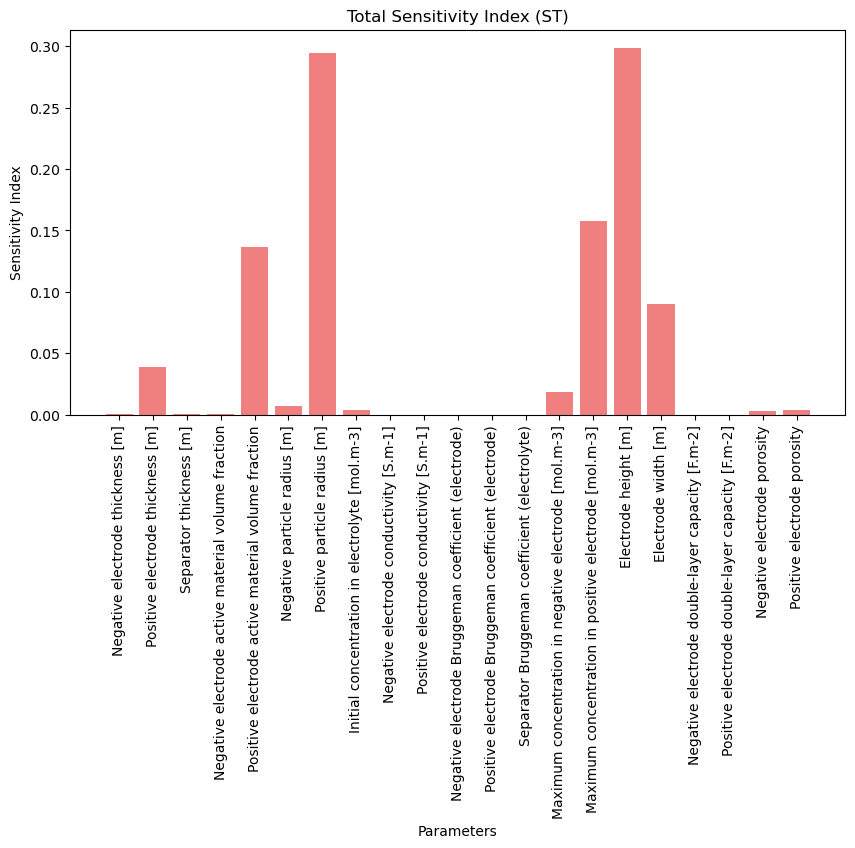

In [63]:
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()